# Validate phenology

Possibilities:
* Validate against
    * flux towers,
    * VODCAv2,
    * TERN phenology
    * PKU-GIMMS.
    * MODIS only
* Inspect how the transition between AVHRR and MODIS impacts trends in seasonal cycle for a sample of ecoregions. And the gapfilling.

In [1]:
%matplotlib inline
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology import phenometrics

## Flux towers

### Get flux data
Flux tower data from OzFlux is in the AusEFlux folder so no need to redownload

Only load sites with >80% homogenous landcover. Using Yi's paper
https://www.sciencedirect.com/science/article/pii/S0034425724001949

Also exclude sites with complex topography as 5km pixel can't account for that.

In [22]:
base = '/g/data/os22/chad_tmp/AusEFlux/'
sites = os.listdir(f'{base}data/training_data/')
homogenous = ['AliceSpringsMulga','DalyUncleared', #'CapeTribulation','CowBay', 'RobsonCreek'
              'DryRiver','Gingin','RiggsCreek','TiTreeEast','HowardSprings',
              'Tumbarumba','Whroo','WombatStateForest']

flux_ts = {}
for site in sites:
    if '.csv' in site:
        if any(h in site for h in homogenous): #only homogenous sites
            print(site[0:-4])
            xx = pd.read_csv(f'{base}data/training_data/{site}',
                             index_col='time', parse_dates=True)

            #convert to 1d xarray
            lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
            xx = xx[['GPP_SOLO_EC']]  #'x_coord', 'y_coord'
            xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
            xx = xx['GPP_SOLO_EC'].squeeze()
            flux_ts[site[0:-4]] = xx
        else:
            continue

DalyUncleared
DryRiver
AliceSpringsMulga
WombatStateForest
HowardSprings
Gingin
TiTreeEast
Tumbarumba
Whroo
RiggsCreek


### Extract phenology forom flux towers and NDVI

In [23]:
# # Savitsky-Golay smoothing function
def sg_smooth(ds):
    return xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )

#### Open NDVI data

In [24]:
path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
ds = xr.open_dataset(path)
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI']

#### Process timeseries and calculate phenometrics

In [34]:
flux_pheno = {}
ndvi_pheno = {}
flux_tss = {}
ndvi_tss = {}

for k,v in flux_ts.items():
    
    # Index NDVI at location and time so we have matching tim series
    lat,lon = v.latitude, v.longitude
    ndvi = ds.sel(latitude=lat, longitude=lon, method='nearest', time=v.time)
    ndvi = ndvi.drop_duplicates(dim='time')
    v = v.sel(time=ndvi.time, method='nearest')

    #smooth
    ndvi = ndvi.resample(time="2W").interpolate("linear")
    v = v.resample(time="2W").interpolate("linear")
    ndvi=sg_smooth(ndvi)
    v=sg_smooth(v)
    
    #interpolate
    ndvi = ndvi.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')
    v = v.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')

    #phenology
    ndvi_phen = phenometrics({k:ndvi}, verbose=False)
    v_phen = phenometrics({k:v}, verbose=False)
    
    # add results to dict for plotting
    flux_tss[k] = v
    ndvi_tss[k] = ndvi
    flux_pheno[k] = v_phen[k]
    ndvi_pheno[k] = ndvi_phen[k]


### Plot

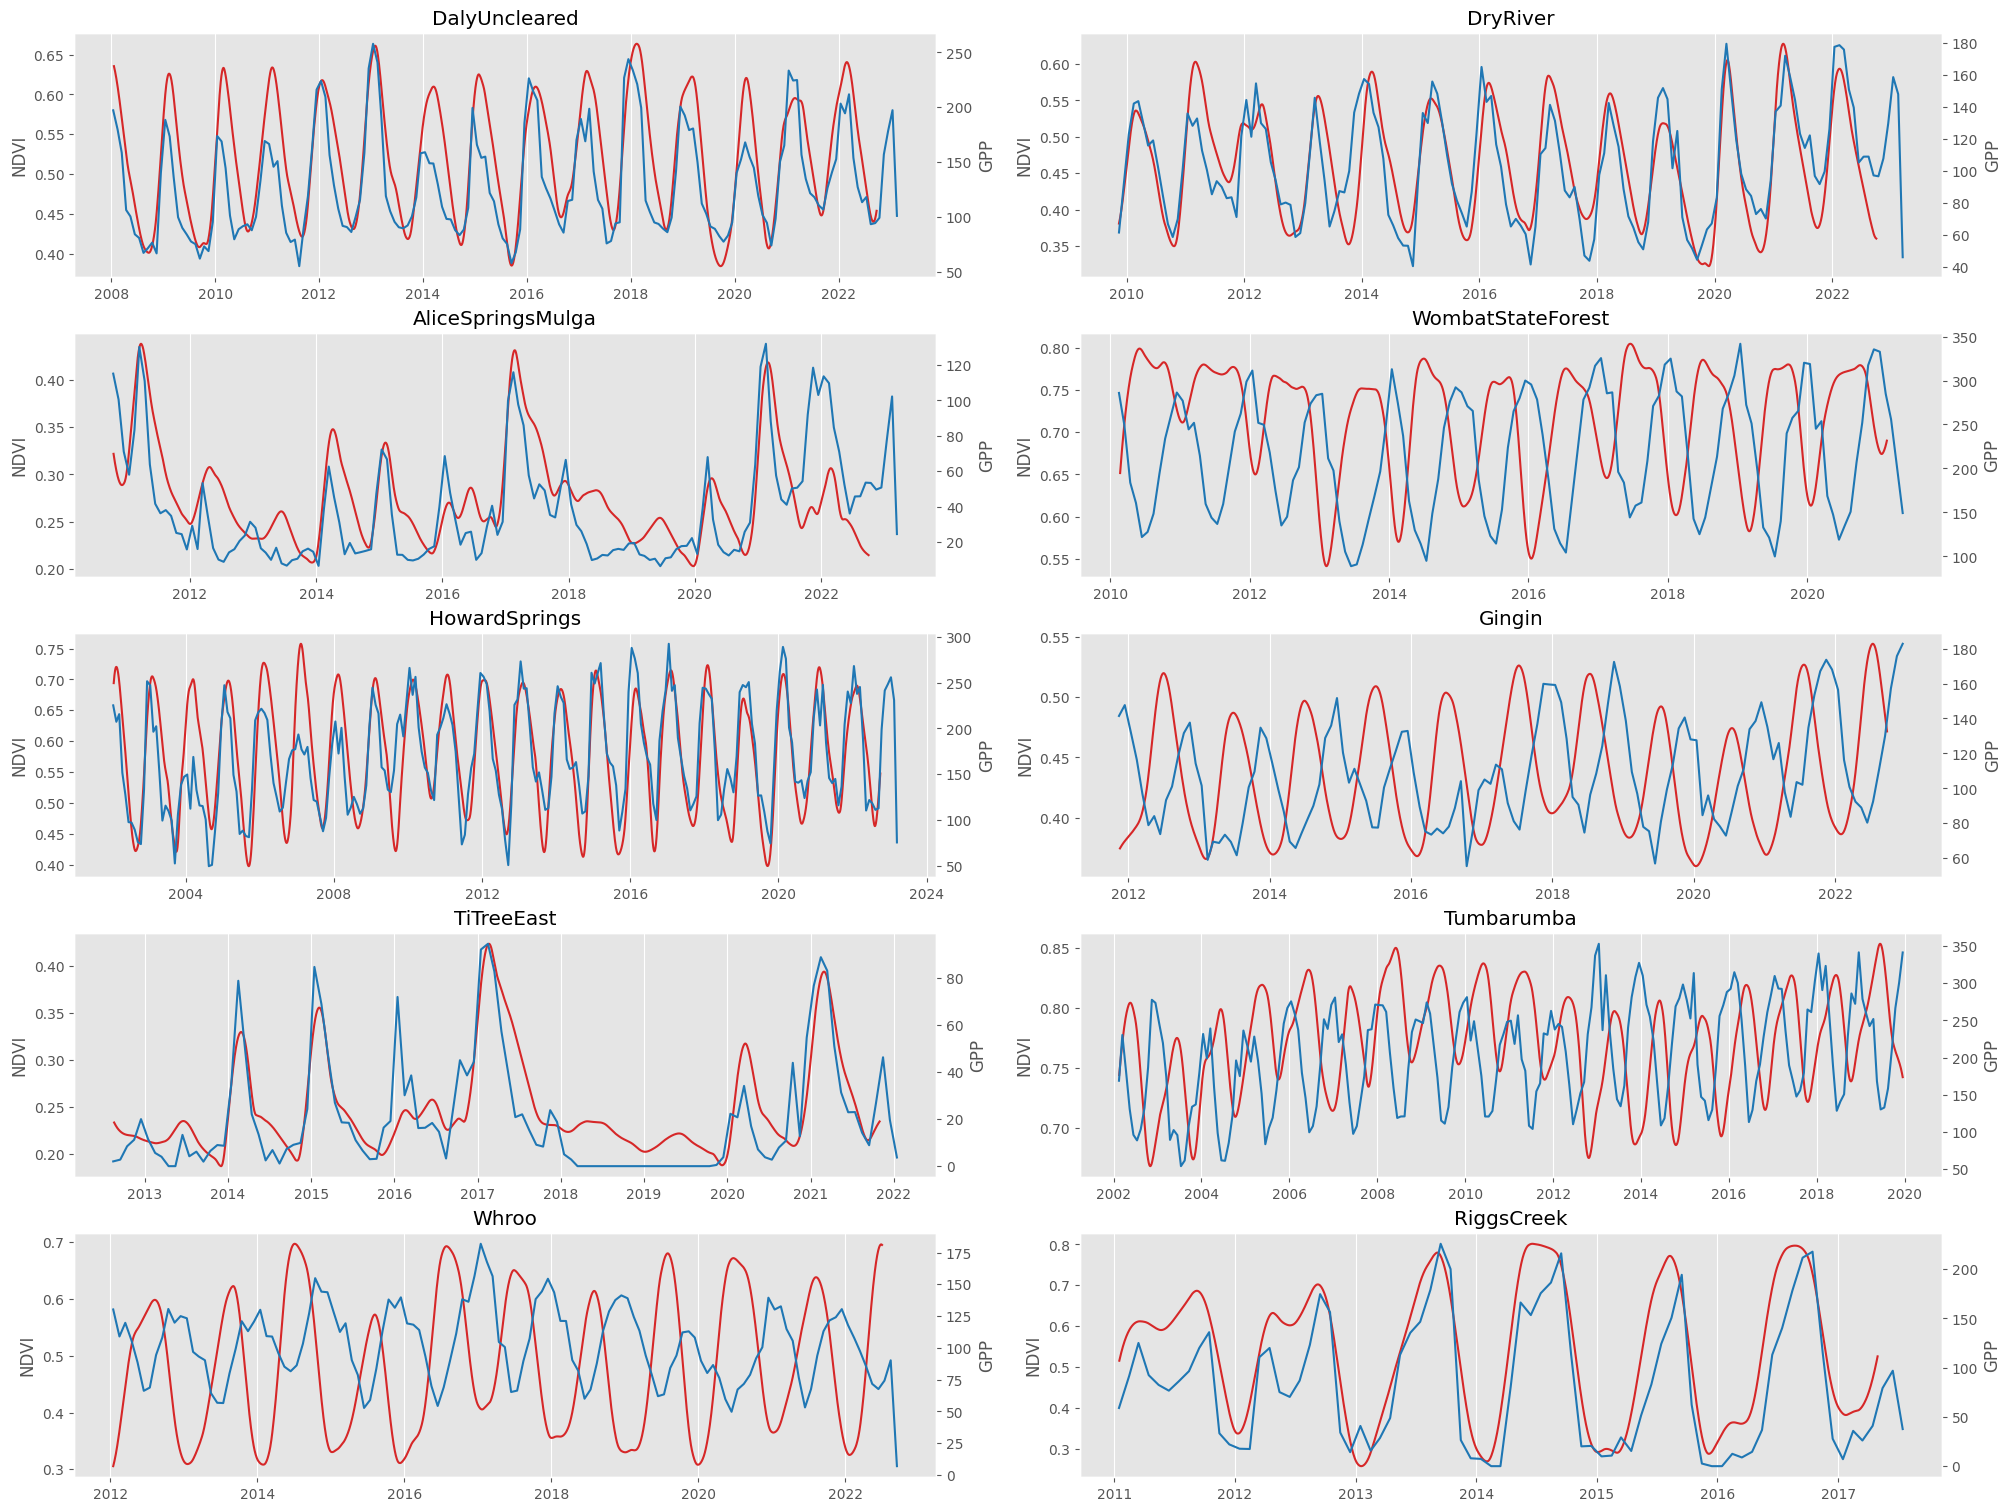

In [39]:
with plt.style.context('ggplot'):
    fig,axes = plt.subplots(5,2, figsize=(20,15), layout='constrained')
    for ax, (k,v) in zip(axes.reshape(-1), flux_ts.items()):
        ax1 = ax.twinx()

        ndvi_tss[k].plot(ax=ax, c='tab:red')
        v.plot(ax=ax1, c='tab:blue')
        ax.set_title(k)
        ax1.set_title(None)
        ax1.grid(None)
        ax.grid(axis='y', which='both')
        ax.set_xlabel(None)
        ax1.set_xlabel(None)
        ax1.set_xlabel(None)
        ax1.set_ylabel('GPP')
        
        # ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(ndvi_pheno[k].SOS.values, ndvi_pheno[k].SOS_year.values)],
        #            y=ndvi_pheno[k].vSOS,
        #           c='tab:green', label='SOS', zorder=10)
        
        # ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(ndvi_pheno[k].EOS.values, ndvi_pheno[k].EOS_year.values)],
        #            y=ndvi_pheno[k].vEOS,
        #           c='tab:purple', label='EOS', zorder=10)
        
        # ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(ndvi_pheno[k].POS.values, ndvi_pheno[k].POS_year.values)],
        #                y=ndvi_pheno[k].vPOS,
        #               c='black', label='POS', zorder=10)
            
        # ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(ndvi_pheno[k].TOS.values, ndvi_pheno[k].TOS_year.values)],
        #            y=ndvi_pheno[k].vTOS,
        #           c='tab:orange', label='TOS', zorder=10)
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/flux_tower_validate.png',
            bbox_inches='tight', dpi=300)